In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-08 15:21:46.348536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-08 15:21:49.806919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:49.831725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:49.831942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 1,
"pred_session_name" : 'rand_walk_interpol',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2023-06-08 15:21:55.201353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:55.201703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:55.201973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 15:21:59.517409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:59.517620: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:21:59.526072: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:21:59.527559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:21:59.527781: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 15:22:00.187768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:00.188052: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:22:00.188455: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:22:00.189055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:00.189244: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-08 15:22:03.061250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:03.061455: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:22:03.061559: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:22:03.061872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:03.062054: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-08 15:22:03.459268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:03.459512: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-08 15:22:03.459771: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-08 15:22:03.460527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:22:03.460728: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 3), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-08--15:22:04'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:
# Use for time profiling
# def main():
#     env.ee.policy = "random"
#     env.ee.action_space.repeat_probability = 0.9
#     all_rewards = []
#     final_errors = []
    
#     for _ in range(1):
#         time_step = train_py_env.reset()
#         reward_in_episode = 0
#         while not time_step.is_last():
#             time_step = train_py_env.step(action=1)
#             reward_in_episode += time_step.reward
#         all_rewards.append(reward_in_episode)
#         final_errors.append(env.current_error)
#     print("Reward per epsisode", np.mean(all_rewards))
#     print("Average error", np.mean(final_errors))
#     env.ee.policy = "rl"

# %lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-08 15:22:05.462198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-08 15:22:06.644721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # # Create a timestep with TF values
        # step_type = tf.constant(time_steps[agent_idx].step_type)
        # reward = tf.constant(time_steps[agent_idx].reward)
        # discount = tf.constant(time_steps[agent_idx].discount)
        # observation = tf.constant(time_steps[agent_idx].observation)
        # tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(time_steps[agent_idx])
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True), n_agents, num_episodes=50)

print((rand_reward, rand_pred_error, np.median(errors)))


2023-06-08 15:22:07.760695: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-08 15:22:07.761217: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-08 15:22:14.479435: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


(20.187533569335937, 19.98833760832462, 18.732480703026273)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp0qe9u8k5.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp0qe9u8k5
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36895


In [17]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[0.4541626 , 0.19597298, 0.        ],
          [0.61265236, 0.19808935, 0.        ],
          [0.5993134 , 0.17375249, 0.        ],
          ...,
          [0.6006226 , 0.20490152, 0.        ],
          [0.56907123, 0.22365206, 0.        ],
          [0.4398743 , 0.26142156, 0.        ]],
  
         [[0.45731616, 0.20752372, 0.        ],
          [0.        , 0.24173933, 0.        ],
          [0.        , 0.19211139, 0.        ],
          ...,
          [0.        , 0.2241509 , 0.        ],
          [0.        , 0.20123747, 0.        ],
          [0.        , 0.19415413, 0.        ]],
  
         [[0.43424502, 0.21694034, 0.        ],
          [0.        , 0.3280066 , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.20107447, 0.        ],
          [0.        , 0.18118249, 0.        ]],
  
         .

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
# This will be a list for multiple agents
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents = n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [22]:
best_reward = np.inf
losses = []
collect_rewards = []

In [23]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [24]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > np.median(errors):
      print("Saving model")
      best_reward = np.median(errors)
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, num_eval_episodes)
      avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True), n_agents, num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return,np.median(errors)))
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {2}'.format(step, avg_return_collect,  np.median(errors_collect)))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3907639) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, b

step = 0: loss = 4.249050140380859,  rew = 0.0


step = 0: Average Return = 19.02028007030487, Average Error = 18.568279178945836, Median Error = 18.568279178945836
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 0: Average Return = 18.669833441674708, Average Error = 18.91524449871877, Median Error = 18.91524449871877
step = 0: Average Return = 19.974630263646443, Average Error = 17.589303056678926, Median Error = 17.589303056678926
step = 1000: loss = 4.198726654052734,  rew = 18.683581054210663
step = 2000: loss = 4.148416996002197,  rew = 21.920587122440338
step = 3000: loss = 4.094207763671875,  rew = 21.86380624771118
step = 4000: loss = 4.045958518981934,  rew = 15.943005681037903
step = 5000: loss = 3.9956464767456055,  rew = 20.91996669769287
step = 6000: loss = 3.9408159255981445,  rew = 20.217400789260864
step = 7000: loss = 3.898042917251587,  rew = 22.14653491973877
step = 8000: loss = 3.907869815826416,  rew = 15.127581357955933
step = 9000: loss = 3.814107894897461,  rew = 20.72138637304306
step = 10000: loss = 3.8104939460754395,  rew = 19.240103662014008
step = 11000: loss = 3.757354259490967,  rew = 16.961969435214996
step = 12000: loss = 3.736112594604492,  rew = 18.85

step = 50000: Average Return = 19.80703029870987, Average Error = 18.020350524677518, Median Error = 18.020350524677518
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 50000: Average Return = 20.023043068250022, Average Error = 17.485363928048393, Median Error = 17.485363928048393
step = 50000: Average Return = 19.177486996452014, Average Error = 18.27085348328814, Median Error = 18.27085348328814
step = 51000: loss = 3.5084216594696045,  rew = 20.688511431217194
step = 52000: loss = 3.5621442794799805,  rew = 21.09740972518921
step = 53000: loss = 3.507237195968628,  rew = 19.0139040350914
step = 54000: loss = 3.6090238094329834,  rew = 21.19368612766266
step = 55000: loss = 3.5775904655456543,  rew = 22.490201890468597
step = 56000: loss = 3.5641610622406006,  rew = 22.0046266913414
step = 57000: loss = 3.52304744720459,  rew = 18.39738041162491
step = 58000: loss = 3.5390677452087402,  rew = 18.208971619606018
step = 59000: loss = 3.53269624710083,  rew = 17.098897695541382
step = 60000: loss = 3.5659401416778564,  rew = 21.467971801757812
step = 61000: loss = 3.552377700805664,  rew = 19.780929386615753
step = 62000: loss = 3.6029906272888

step = 250000: Average Return = 20.537226410309472, Average Error = 17.649810768231355, Median Error = 17.649810768231355
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 250000: Average Return = 21.195511695543924, Average Error = 16.55464040845999, Median Error = 16.55464040845999
step = 250000: Average Return = 21.45421810269356, Average Error = 16.100259439430697, Median Error = 16.100259439430697
step = 251000: loss = 3.315626621246338,  rew = 20.795434713363647
step = 252000: loss = 3.347400188446045,  rew = 22.377905249595642
step = 253000: loss = 3.3165359497070312,  rew = 19.44655478000641
step = 254000: loss = 3.396146297454834,  rew = 18.718568980693817
step = 255000: loss = 3.3020083904266357,  rew = 22.27327823638916
step = 256000: loss = 3.278538942337036,  rew = 19.685064256191254
step = 257000: loss = 3.287907600402832,  rew = 18.413028120994568
step = 258000: loss = 3.2621798515319824,  rew = 19.127942621707916
step = 259000: loss = 3.368093729019165,  rew = 20.446383953094482
step = 260000: loss = 3.431656837463379,  rew = 19.281132519245148
step = 261000: loss = 3.293342113494873,  rew = 20.140214264392853
step = 262000: loss =

step = 300000: Average Return = 20.203175198336442, Average Error = 17.337636260816822, Median Error = 17.337636260816822
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 300000: Average Return = 21.352748080094656, Average Error = 16.433684205277142, Median Error = 16.433684205277142
step = 300000: Average Return = 20.531080641150474, Average Error = 17.32207314409746, Median Error = 17.32207314409746
step = 301000: loss = 3.3859434127807617,  rew = 20.830532908439636
step = 302000: loss = 3.2960586547851562,  rew = 21.79139256477356
step = 303000: loss = 3.32627272605896,  rew = 18.43547523021698
step = 304000: loss = 3.3565852642059326,  rew = 20.67582607269287
step = 305000: loss = 3.2535412311553955,  rew = 22.161880135536194
step = 306000: loss = 3.381993532180786,  rew = 18.130595982074738
step = 307000: loss = 3.309828281402588,  rew = 20.8195760846138
step = 308000: loss = 3.3302855491638184,  rew = 20.18931210041046
step = 309000: loss = 3.36897349357605,  rew = 21.17508202791214
step = 310000: loss = 3.3380260467529297,  rew = 21.872518956661224
step = 311000: loss = 3.30519962310791,  rew = 19.739286601543427
step = 312000: loss = 3.3

step = 350000: Average Return = 20.74596907377243, Average Error = 16.760206898273857, Median Error = 16.760206898273857
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 350000: Average Return = 19.17309867123763, Average Error = 18.21886115738987, Median Error = 18.21886115738987
step = 350000: Average Return = 19.971412555873393, Average Error = 17.68615435491573, Median Error = 17.68615435491573
step = 351000: loss = 3.3708302974700928,  rew = 19.448433816432953
step = 352000: loss = 3.3468360900878906,  rew = 22.90932983160019
step = 353000: loss = 3.367579460144043,  rew = 18.274034559726715
step = 354000: loss = 3.378377914428711,  rew = 21.783100068569183
step = 355000: loss = 3.251768112182617,  rew = 19.467058777809143
step = 356000: loss = 3.4235968589782715,  rew = 19.83526647090912
step = 357000: loss = 3.2738494873046875,  rew = 22.271405160427094
step = 358000: loss = 3.352158546447754,  rew = 18.676680326461792
step = 359000: loss = 3.362360954284668,  rew = 20.258910953998566
step = 360000: loss = 3.3639378547668457,  rew = 20.0087308883667
step = 361000: loss = 3.335434913635254,  rew = 15.856415033340454
step = 362000: loss = 3

step = 500000: Average Return = 20.225309433142343, Average Error = 16.658748165477736, Median Error = 16.658748165477736
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-08--15:22:04/assets


step = 500000: Average Return = 20.68914987385273, Average Error = 17.05463553249335, Median Error = 17.05463553249335
step = 500000: Average Return = 20.91678536693255, Average Error = 16.958717499357906, Median Error = 16.958717499357906
step = 501000: loss = 3.4355363845825195,  rew = 18.701349198818207
step = 502000: loss = 3.227386236190796,  rew = 21.537142992019653
step = 503000: loss = 3.20628023147583,  rew = 18.303295969963074
step = 504000: loss = 3.3513314723968506,  rew = 18.573638796806335
step = 505000: loss = 3.3883044719696045,  rew = 22.3893865942955
step = 506000: loss = 3.375816822052002,  rew = 21.183884143829346
step = 507000: loss = 3.2660059928894043,  rew = 18.999630212783813
step = 508000: loss = 3.390324115753174,  rew = 21.333013474941254
step = 509000: loss = 3.322314500808716,  rew = 22.747503221035004
step = 510000: loss = 3.3647522926330566,  rew = 15.633966028690338
step = 511000: loss = 3.3109230995178223,  rew = 18.522299826145172
step = 512000: loss 

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

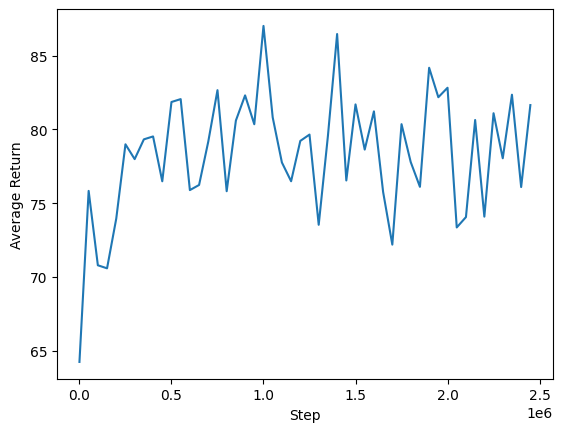

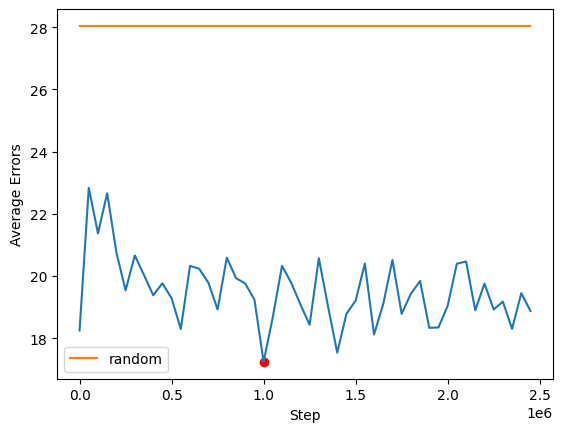

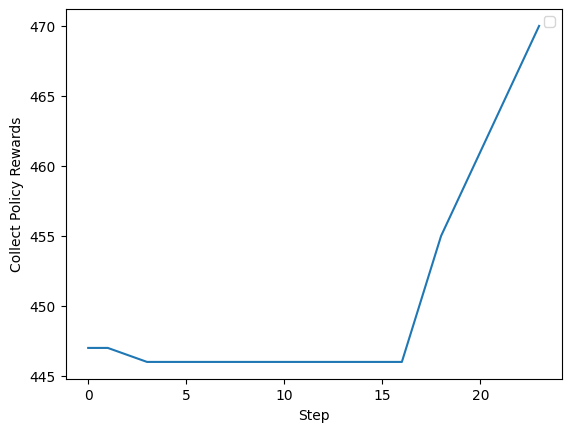

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error, errors = compute_avg_return(eval_py_env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), n_agents, 500)
print(avg_return, avg_error)

21.13953922434524 19.450520444988275


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
saved_policy.time_step_spec = agent.policy.time_step_spec
saved_policy.action_spec = agent.policy.action_spec
saved_policy.policy_state_spec = agent.policy.policy_state_spec
saved_policy.info_spec = agent.policy.info_spec
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(saved_policy, use_tf_function=True), n_agents, 500)
print(avg_return, avg_error, np.median(errors))

21.163968264460564 19.648986952774788 16.59833196364828
